import modules

In [1]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence, dist, dim_specific_MSE, dim_specific_dist, distV2
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


set device

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate dataset

In [3]:
grid = t.zeros((2, 30, 30), device=device)
grid[:] = 50
grid[0, 12:17] = 90

gamma = 0.005
k1 = k1_bar = 0.98
k2 = k2_bar = 0.1
k3 = k3_bar = 0.2

N = 100
num_steps = 1_000
DA = 0.1
DB = 0.4

sequence = generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=True,
    gamma=gamma,
    k1=k1,
    k1_bar=k1_bar,
    k2=k2,
    k2_bar=k2_bar,
    k3=k3,
    k3_bar=k3_bar,
)
dataset = chop_and_shuffle_data(sequence, shuffle=True)
if device == "cuda":
    dataset.cuda()
print(f"created dataset with shape: {dataset.shape}")


  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:06<00:00, 166.25it/s]

created dataset with shape: torch.Size([999, 2, 2, 30, 30])


visualize the gradient for a range of DA values when varying DB, using the sum of the dimension-specific losses. Rate constants and reaction time constant are not varied.

In [6]:
# define a sequence of DA values to test
DA_vals = t.linspace(0.0, 1.0, 100, device=device)
# split the dataset for usage
X = dataset[:,0]
Y_obs = dataset[:,1]
# define a sequence of DB values to test
DB_vals = t.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], device=device)
# rate coefficients
k1 = t.tensor(0.98, device=device)
k1_bar = t.tensor(0.98, device=device)
k2 = t.tensor(0.1, device=device)
k2_bar = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.005, device=device)


# collect the results of each test run here
grads = []
distances = []
# iterate over the DB values
for DB in tqdm(DB_vals):
    # collect the results of the current test run
    distances_cur = []
    grads_cur = []
    # iterate over the DA values
    for DA in DA_vals:
        dist_vals = []
        grad_vals = []
        # For each DA value, we simulate and backpropagate 5 times,
        # averaging the distance and the gradient of each run
        for run in range(5):
            DA.requires_grad_()
            # 1. run the diffusion step on each sample
            diffused_samples = diffuse_STE(X, N, DA, DB)
            # 2. run the reaction step on each sample
            Y_sim = rho_STE(diffused_samples, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
            # use the sum of dim-specific distances
            dist_val = distV2(X, Y_sim, Y_obs)
            dist_vals.append(dist_val.detach().cpu().numpy())
            gradient = t.autograd.grad(dist_val, DA)[0]
            grad_vals.append(gradient.detach().cpu().numpy())
        distances_cur.append(np.mean(dist_vals))
        grads_cur.append(np.mean(grad_vals))
    distances.append(distances_cur)
    grads.append(grads_cur)

100%|██████████| 9/9 [54:52<00:00, 365.87s/it]


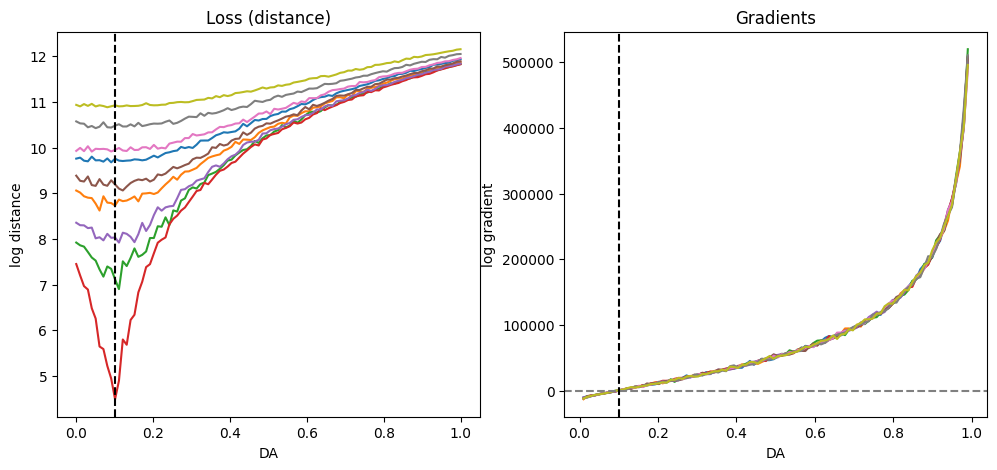

In [7]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
for idx in range(9):
    axs[0].plot(DA_vals.cpu(), np.log(np.array(distances[idx])), label=f"D_B: {DB_vals[idx]:.2f}")
    axs[1].plot(DA_vals.cpu(), np.array(grads[idx]), label=f"D_B: {DB_vals[idx]:.2f}")
axs[0].set(title="Loss (distance)", xlabel="DA", ylabel="log distance")
axs[1].set(title="Gradients", xlabel="DA", ylabel="log gradient")

axs[0].axvline(0.1, color='black', linestyle="--", label="original DA value")
axs[1].axhline(0., color='gray', linestyle="--", label="zero-gradient line")
axs[1].axvline(0.1, color='black', linestyle="--", label="original DA value")